<a href="https://colab.research.google.com/github/eyenpi/SNeurodCNN_Unofficial/blob/main/NAML_Project_v0_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DOWNLOAD DATA

You have to download the data from google drive and then tweak the paths below accordingly.

https://drive.google.com/drive/folders/1G1CrE6r-DP3bq4CZEKlp1oZ9lTmQSbKQ?usp=sharing

In [85]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [94]:
import pathlib

nii_file_path = "/content/drive/MyDrive/Polimi/NAML/MALPEM-ADNI_test.nii"
data_dir_train = pathlib.Path("/content/drive/MyDrive/Polimi/NAML/Deep-convolutional-neural-network-classifier-for-Alzheimer-s-Disease-1")
alzheimer_model_path = "/content/drive/MyDrive/Polimi/NAML/alzheimer_model.pth"

class_names = ['MIDSAG-ADGAMMA', 'MIDSAG-MCIGAMMA', 'MTL AD-GAMMA', 'MTL-MCI']

# Pre-processing: Gamma correction

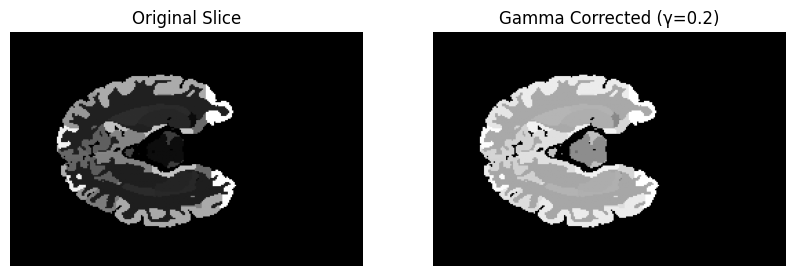

In [88]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

nii_img = nib.load(nii_file_path)

nii_data = nii_img.get_fdata()

slice_idx = nii_data.shape[2] // 2
nii_slice = nii_data[:, :, slice_idx]

nii_slice = nii_slice - nii_slice.min()
nii_slice = nii_slice / nii_slice.max()

gamma = 0.2
gamma_corrected = np.power(nii_slice, gamma)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(nii_slice, cmap="gray")
ax[0].set_title("Original Slice")
ax[0].axis("off")

ax[1].imshow(gamma_corrected, cmap="gray")
ax[1].set_title(f"Gamma Corrected (γ={gamma})")
ax[1].axis("off")

plt.show()

# Load Data

In [ ]:
import os
import cv2
import glob
import numpy as np

img_data = []
label = []

IMG_HEIGHT = 180
IMG_WIDTH = 180

for i in os.listdir(data_dir_train):
    impath = os.path.join(data_dir_train,i)
    im = glob.glob(impath + '/*.png')
    print(len(im))
    for j in im:
        img= cv2.imread(j)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        img = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH),interpolation = cv2.INTER_AREA)
        img=np.array(img)
        img = img.astype('float32')
        img_data.append(img)
        label.append(i)

2160
2700
2820
2068
0
0
0
0
0
0
0
0
0
0


# Visualization

4044
3081
892
3922
2627
1125
559
3133
2595


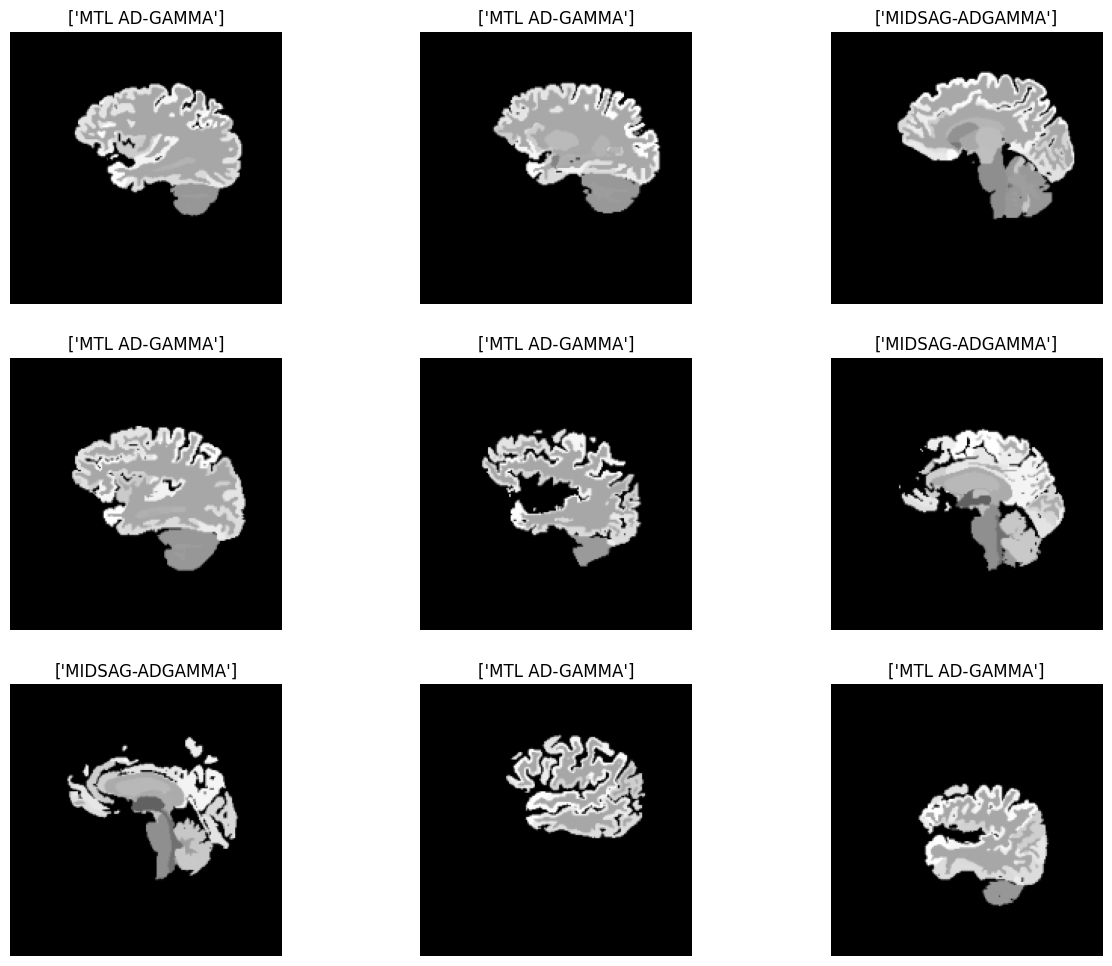

In [89]:
import matplotlib.pyplot as plt
import random

fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(15, 12))

for i in range(9):
    num=random.randint(0,4120)
    print(num)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(img_data[num].astype("uint8"), cmap= "gray")
    plt.title([label[num]])
    plt.axis("off")

# Data Split for Train, Validation and Test

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_others, y_train, y_others = train_test_split(img_data, y, test_size=0.2, random_state=0, stratify=y)
X_valid, X_test, y_valid, y_test = train_test_split(X_others, y_others, test_size=0.5, random_state=0, stratify=y_others)

# Data processing for PyTorch

In [ ]:
import torch

X_train = np.array(X_train).reshape(-1, 180, 180, 1)
X_valid = np.array(X_valid).reshape(-1, 180, 180, 1)
X_test = np.array(X_test).reshape(-1, 180, 180, 1)

X_train = X_train / 255.0
X_valid = X_valid / 255.0
X_test = X_test / 255.0

X_train = X_train.transpose(0, 3, 1, 2)
X_valid = X_valid.transpose(0, 3, 1, 2)
X_test = X_test.transpose(0, 3, 1, 2)

X_train = torch.FloatTensor(X_train)
X_valid = torch.FloatTensor(X_valid)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train)
y_valid = torch.LongTensor(y_valid)
y_test = torch.LongTensor(y_test)

# Generate Dataset and Dataloader

In [ ]:
from torch.utils.data import Dataset, DataLoader

class AlzheimerDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

train_dataset = AlzheimerDataset(X_train, y_train)
valid_dataset = AlzheimerDataset(X_valid, y_valid)
test_dataset = AlzheimerDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define Model

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class AlzheimerCNN(nn.Module):
    def __init__(self, num_classes=4):
        super(AlzheimerCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)

        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(64 * 44 * 44, 500)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(500, num_classes)

        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)

        x = F.relu(self.conv2(x))

        x = F.relu(self.conv3(x))
        x = self.pool2(x)

        x = x.view(x.size(0), -1)

        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x

In [ ]:
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AlzheimerCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

In [ ]:
print(model)
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params}")

AlzheimerCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=123904, out_features=500, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=500, out_features=4, bias=True)
)
Total parameters: 61982568


In [ ]:
from torchsummary import summary

summary(model, (1, 180, 180))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 178, 178]             320
         MaxPool2d-2           [-1, 32, 89, 89]               0
            Conv2d-3           [-1, 32, 89, 89]           9,248
            Conv2d-4           [-1, 64, 89, 89]          18,496
         MaxPool2d-5           [-1, 64, 44, 44]               0
            Linear-6                  [-1, 500]      61,952,500
           Dropout-7                  [-1, 500]               0
            Linear-8                    [-1, 4]           2,004
Total params: 61,982,568
Trainable params: 61,982,568
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.12
Forward/backward pass size (MB): 16.42
Params size (MB): 236.44
Estimated Total Size (MB): 252.99
----------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


# Train the Model

In [ ]:
def train_model(model, train_loader, valid_loader, criterion, optimizer, num_epochs=100, patience=5):
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None

    train_losses = []
    train_accs = []
    valid_losses = []
    valid_accs = []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_train_loss = running_loss / len(train_loader.dataset)
        epoch_train_acc = correct / total
        train_losses.append(epoch_train_loss)
        train_accs.append(epoch_train_acc)

        # Validation phase
        model.eval()
        running_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in valid_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                running_loss += loss.item() * inputs.size(0)

                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        epoch_valid_loss = running_loss / len(valid_loader.dataset)
        epoch_valid_acc = correct / total

        valid_losses.append(epoch_valid_loss)
        valid_accs.append(epoch_valid_acc)
        scheduler.step(epoch_valid_loss)

        print(f'Epoch {epoch+1}/{num_epochs}, '
              f'Train Loss: {epoch_train_loss:.4f}, '
              f'Train Acc: {epoch_train_acc:.4f}, '
              f'Valid Loss: {epoch_valid_loss:.4f}, '
              f'Valid Acc: {epoch_valid_acc:.4f}, '
              f'LR: {optimizer.param_groups[0]["lr"]:.6f}')

        # Early stopping check
        if epoch_valid_loss < best_val_loss:
            best_val_loss = epoch_valid_loss
            patience_counter = 0
            best_model_state = model.state_dict().copy()
        else:
            patience_counter += 1
            print(f'Validation loss did not improve, patience: {patience_counter}/{patience}')
            if patience_counter >= patience:
                print(f'Early stopping at epoch {epoch+1}')
                break

    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print(f'Loaded best model with validation loss: {best_val_loss:.4f}')

    return model, train_losses, train_accs, valid_losses, valid_accs

In [ ]:
model, train_losses, train_accs, valid_losses, valid_accs = train_model(
    model, train_loader, valid_loader, criterion, optimizer
)

torch.save(model.state_dict(), alzheimer_model_path)

Epoch 1/100, Train Loss: 1.4338, Train Acc: 0.5734, Valid Loss: 0.6126, Valid Acc: 0.7067, LR: 0.000100
Epoch 2/100, Train Loss: 0.5900, Train Acc: 0.7279, Valid Loss: 0.4766, Valid Acc: 0.8000, LR: 0.000100
Epoch 3/100, Train Loss: 0.4112, Train Acc: 0.8211, Valid Loss: 0.3699, Valid Acc: 0.8513, LR: 0.000100
Epoch 4/100, Train Loss: 0.2811, Train Acc: 0.8904, Valid Loss: 0.2954, Valid Acc: 0.8872, LR: 0.000100
Epoch 5/100, Train Loss: 0.1841, Train Acc: 0.9318, Valid Loss: 0.2341, Valid Acc: 0.9210, LR: 0.000100
Epoch 6/100, Train Loss: 0.1272, Train Acc: 0.9568, Valid Loss: 0.1960, Valid Acc: 0.9272, LR: 0.000100
Epoch 7/100, Train Loss: 0.0914, Train Acc: 0.9713, Valid Loss: 0.1418, Valid Acc: 0.9518, LR: 0.000100
Epoch 8/100, Train Loss: 0.0674, Train Acc: 0.9790, Valid Loss: 0.1321, Valid Acc: 0.9559, LR: 0.000100
Epoch 9/100, Train Loss: 0.0542, Train Acc: 0.9831, Valid Loss: 0.1022, Valid Acc: 0.9641, LR: 0.000100
Epoch 10/100, Train Loss: 0.0395, Train Acc: 0.9892, Valid Loss:

# Test the Model

In [90]:
model = AlzheimerCNN()
model.load_state_dict(torch.load(alzheimer_model_path))
model = model.to(device)

def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_preds), np.array(all_labels)

<ipython-input-90-7ce8eb8e13dc>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(alzheimer_model_path))


In [91]:
y_pred, y_test_np = evaluate_model(model, test_loader)

# Test Metrics

In [92]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, ConfusionMatrixDisplay
import numpy as np

accuracy = accuracy_score(y_test_np, y_pred)
precision = precision_score(y_test_np, y_pred, average="weighted")
recall = recall_score(y_test_np, y_pred, average="weighted")
f1 = f1_score(y_test_np, y_pred, average="weighted")

cm = confusion_matrix(y_test_np, y_pred)

sensitivity_per_class = []
specificity_per_class = []
n_classes = cm.shape[0]
for i in range(n_classes):
    true_pos = cm[i, i]
    false_neg = np.sum(cm[i, :]) - true_pos
    true_neg = np.sum(np.delete(np.delete(cm, i, axis=0), i, axis=1))
    false_pos = np.sum(np.delete(cm[:, i], i))

    sensitivity = true_pos / (true_pos + false_neg) if (true_pos + false_neg) > 0 else 0
    sensitivity_per_class.append(sensitivity)

    specificity = true_neg / (true_neg + false_pos) if (true_neg + false_pos) > 0 else 0
    specificity_per_class.append(specificity)

# Macro average sensitivity and specificity
sensitivity = np.mean(sensitivity_per_class)
specificity = np.mean(specificity_per_class)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("Sensitivity (calculated per class):", sensitivity)
print("Specificity:", specificity)
print("F1 Score:", f1)

Accuracy: 0.9825641025641025
Precision: 0.9827436143358265
Recall: 0.9825641025641025
Sensitivity (calculated per class): 0.9818630726008155
Specificity: 0.9941068317683575
F1 Score: 0.98254588308319


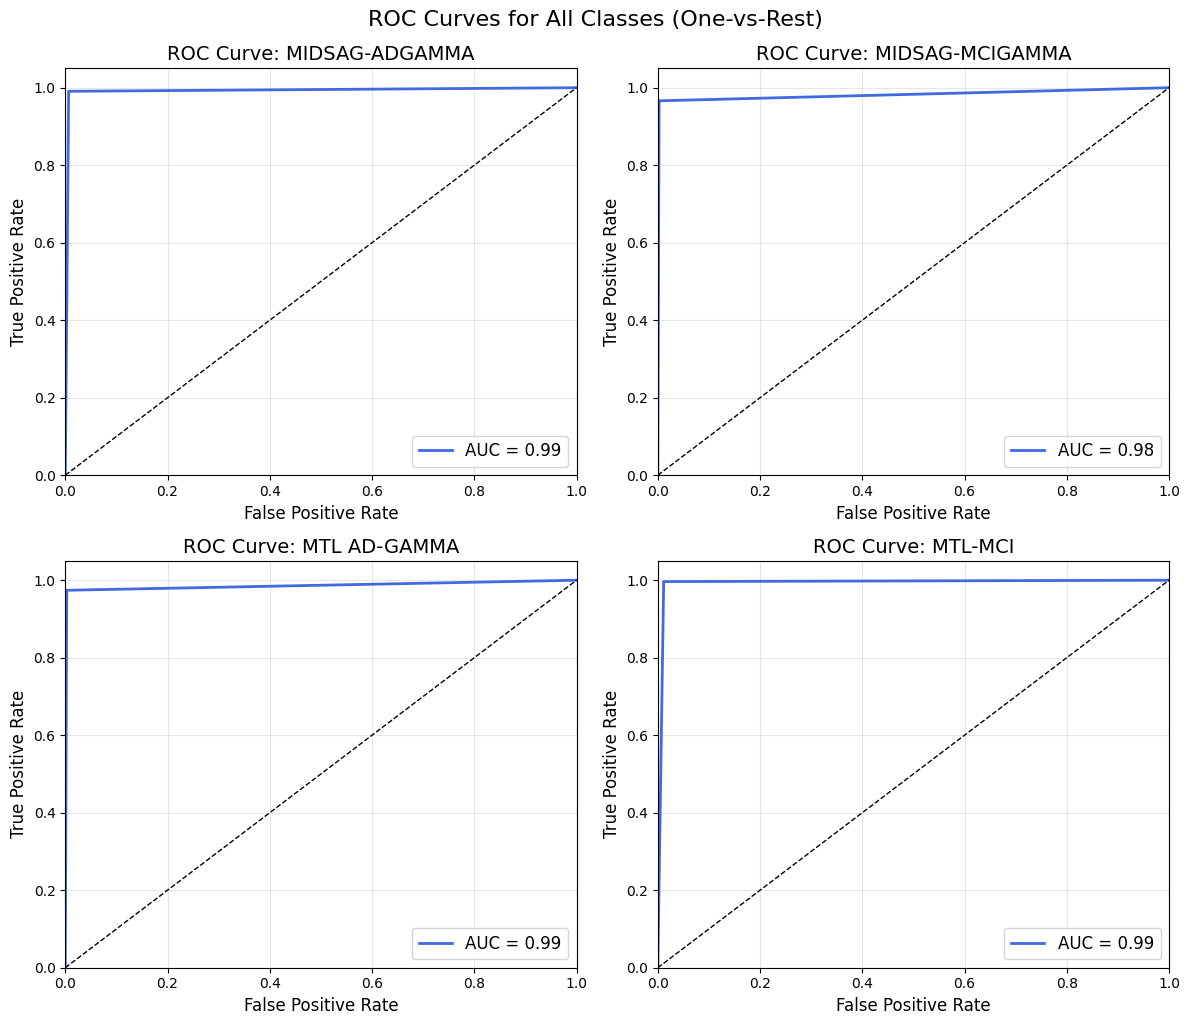

In [95]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import numpy as np

def plot_roc_four_classes(y_test, y_pred, class_names=None):

    if class_names is None:
        class_names = [f'Class {i}' for i in range(4)]

    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.flatten()

    for i in range(4):
        ax = axes[i]

        y_true_binary = (y_test == i).astype(int)
        y_pred_binary = (y_pred == i).astype(int)

        fpr, tpr, _ = roc_curve(y_true_binary, y_pred_binary)
        roc_auc = auc(fpr, tpr)

        ax.plot(fpr, tpr, lw=2, color='royalblue', label=f'AUC = {roc_auc:.2f}')

        ax.plot([0, 1], [0, 1], 'k--', lw=1)

        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate', fontsize=12)
        ax.set_ylabel('True Positive Rate', fontsize=12)
        ax.set_title(f'ROC Curve: {class_names[i]}', fontsize=14)
        ax.legend(loc="lower right", fontsize=12)
        ax.grid(alpha=0.3)

    plt.tight_layout()
    plt.suptitle('ROC Curves for All Classes (One-vs-Rest)', fontsize=16, y=1.02)
    plt.show()

plot_roc_four_classes(y_test_np, y_pred, class_names=class_names)

<Figure size 1000x800 with 0 Axes>

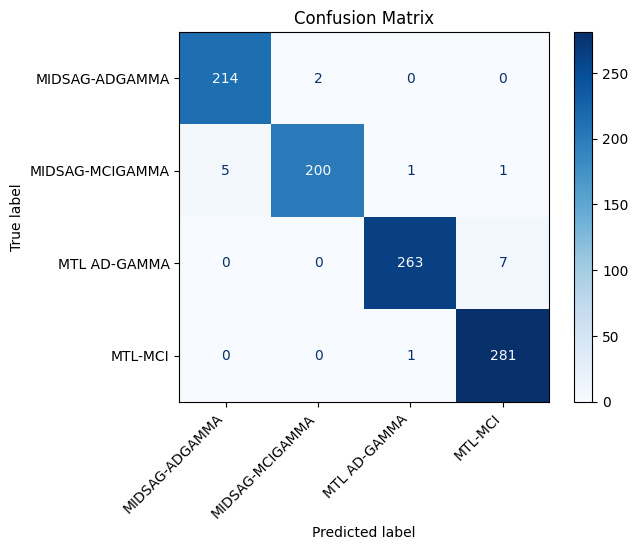

In [96]:
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.xticks(rotation=45, ha='right')
plt.title('Confusion Matrix')
plt.show()

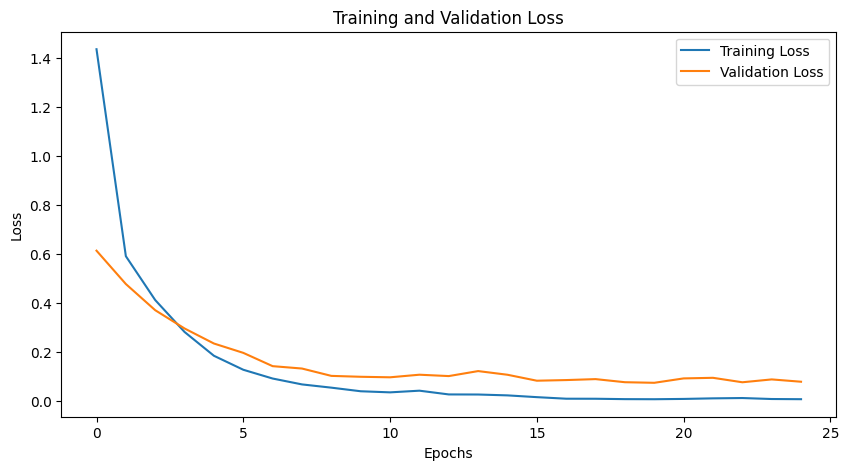

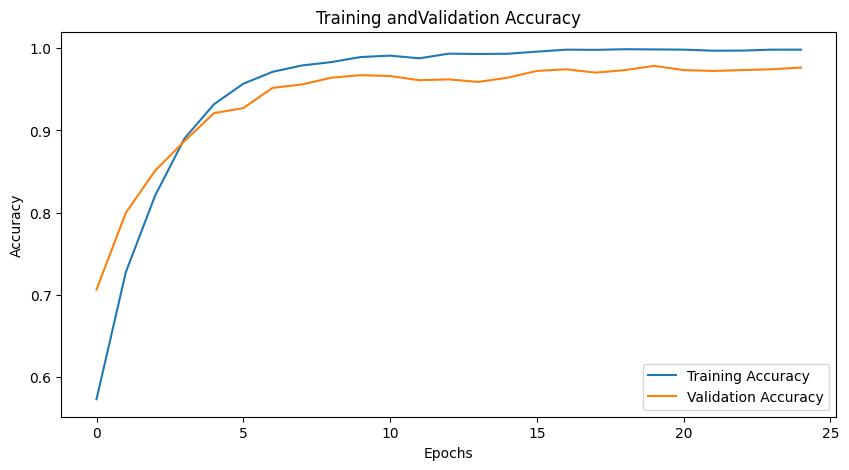

In [97]:

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('loss_curves.png')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(train_accs, label='Training Accuracy')
plt.plot(valid_accs, label='Validation Accuracy')
plt.title('Training andValidation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('accuracy_curve.png')
plt.show()


# Explainability using GradCam

In [98]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        # Register hooks
        self.register_hooks()

    def register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()

        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0].detach()

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def generate_cam(self, input_image, target_class=None):
        device = next(self.model.parameters()).device
        input_image = input_image.to(device)

        self.model.eval()

        output = self.model(input_image)

        if target_class is None:
            pred_prob, pred_class = torch.max(F.softmax(output, dim=1), dim=1)
            target_class = pred_class.item()
        else:
            pred_prob, pred_class = torch.max(F.softmax(output, dim=1), dim=1)
            pred_class = pred_class.item()
            pred_prob = pred_prob.item()

        self.model.zero_grad()

        one_hot = torch.zeros_like(output)
        one_hot[0, target_class] = 1

        output.backward(gradient=one_hot, retain_graph=True)
        gradients = self.gradients.mean(dim=(2, 3), keepdim=True)

        # Weight the activations by the gradients
        cam = torch.sum(gradients * self.activations, dim=1, keepdim=True)
        cam = F.relu(cam)

        # Normalize the CAM
        cam = cam - cam.min()
        if cam.max() > 0:
            cam = cam / cam.max()

        cam = F.interpolate(cam, size=input_image.shape[2:], mode='bilinear', align_corners=False)

        return cam.squeeze().cpu().numpy(), pred_class, pred_prob.item()

In [99]:
def visualize_gradcam_from_dataset(model, test_loader, num_samples=5, target_class=None, layer=None):
    # Use the last convolutional layer if not specified
    if layer is None:
        layer = model.conv3

    device = next(model.parameters()).device

    grad_cam = GradCAM(model, layer)

    dataiter = iter(test_loader)
    images, labels = next(dataiter)

    model.eval()

    fig = plt.figure(figsize=(15, num_samples * 5))

    for i in range(min(num_samples, len(images))):
        image_tensor = images[i:i+1].to(device)
        true_label = labels[i].item()

        cam, pred_class, pred_prob = grad_cam.generate_cam(image_tensor, target_class)

        image = image_tensor.cpu().squeeze().numpy()

        heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
        heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
        heatmap = np.float32(heatmap) / 255

        image_rgb = np.stack([image, image, image], axis=2)
        blended = 0.7 * image_rgb + 0.3 * heatmap

        ax1 = fig.add_subplot(num_samples, 3, i*3 + 1)
        ax1.imshow(image, cmap='gray')
        ax1.set_title(f'Original (True: {class_names[true_label]})')
        ax1.axis('off')

        ax2 = fig.add_subplot(num_samples, 3, i*3 + 2)
        ax2.imshow(heatmap)
        ax2.set_title('GradCAM Heatmap')
        ax2.axis('off')

        ax3 = fig.add_subplot(num_samples, 3, i*3 + 3)
        ax3.imshow(blended)
        ax3.set_title(f'Overlay (Pred: {class_names[pred_class]}, {pred_prob:.2f})')
        ax3.axis('off')

    plt.tight_layout()
    return fig

def run_gradcam_examples(model, test_loader, X_test, y_test):
    device = next(model.parameters()).device

    print("Visualizing GradCAM for random samples from test loader...")
    fig1 = visualize_gradcam_from_dataset(model, test_loader, num_samples=3)
    plt.figure(fig1.number)
    plt.savefig('gradcam_samples.png')
    plt.show()

<ipython-input-100-1171b9c7e499>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(alzheimer_model_path))


Visualizing GradCAM for random samples from test loader...


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


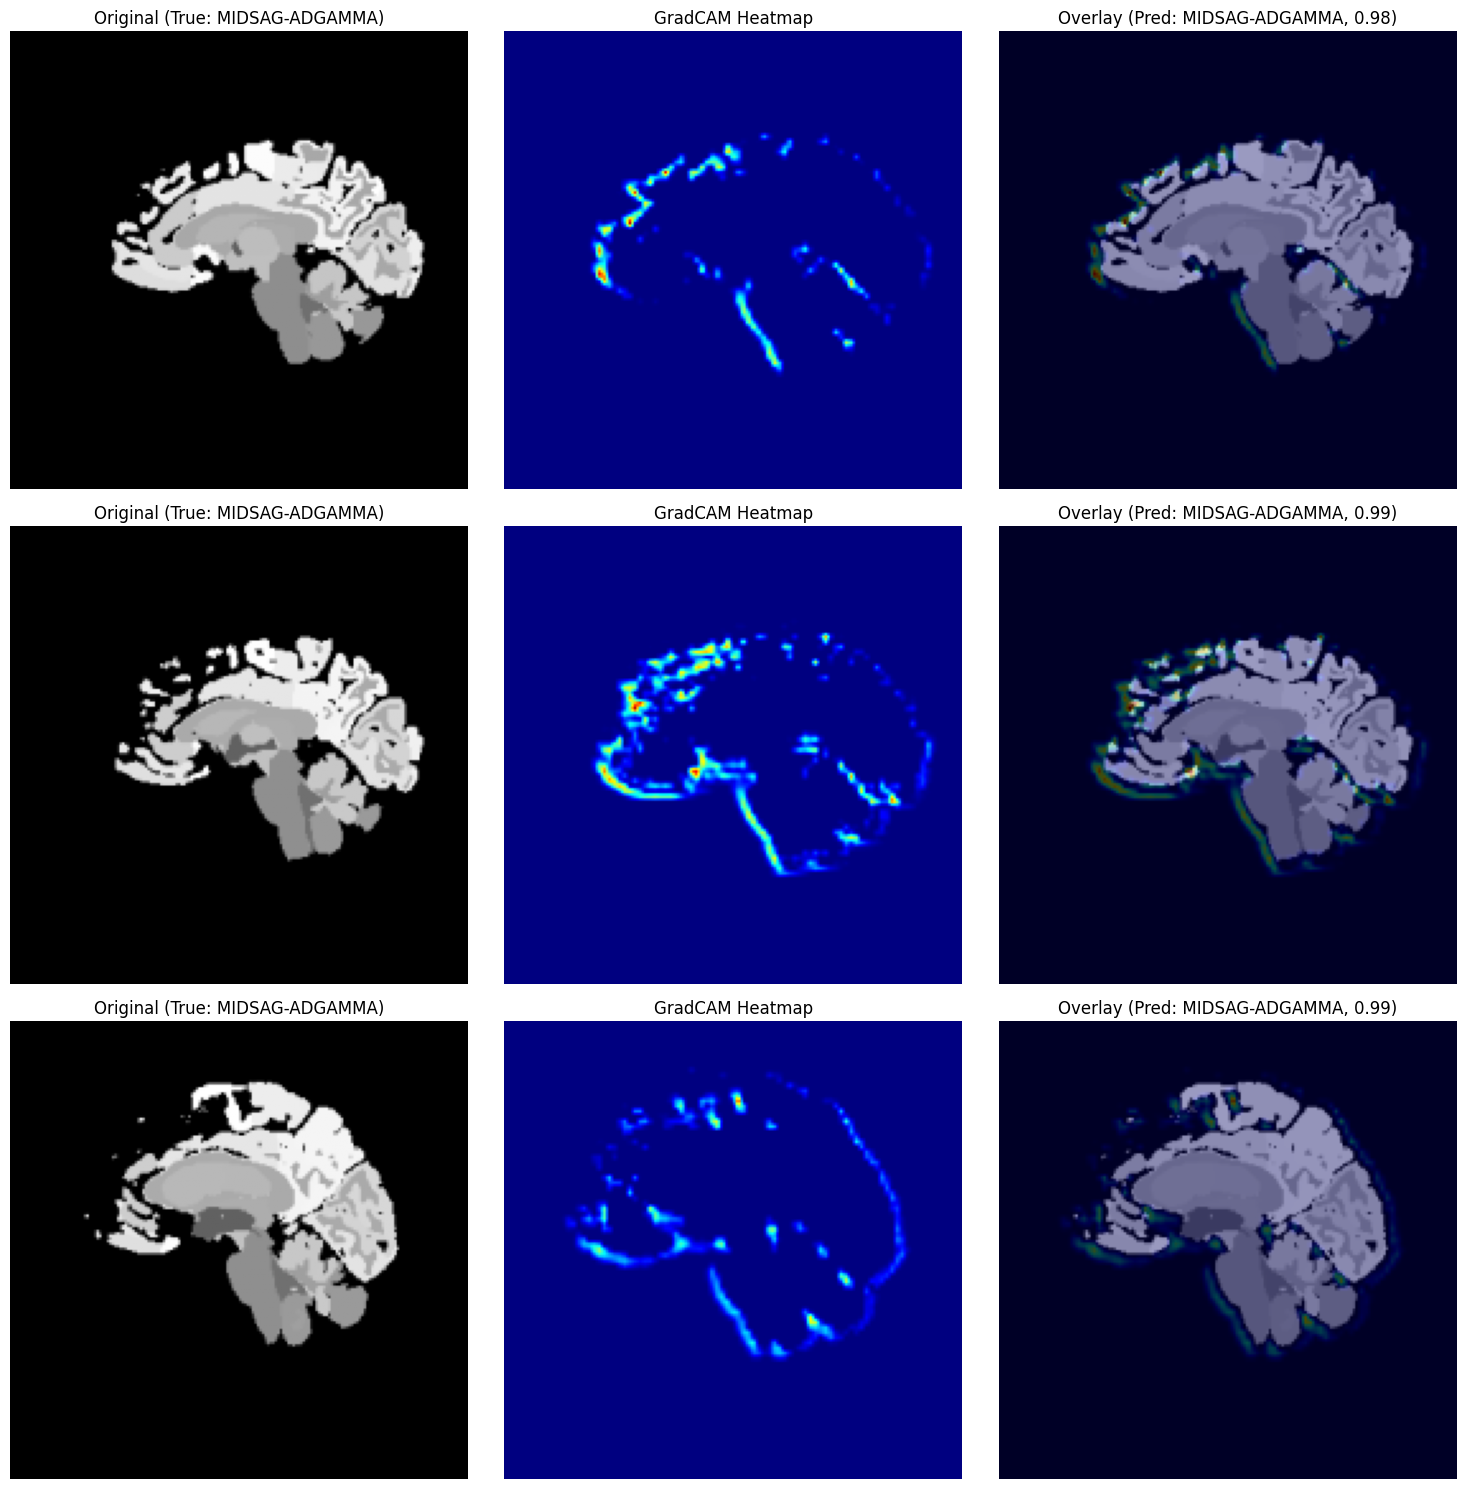

In [100]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = AlzheimerCNN()
model.load_state_dict(torch.load(alzheimer_model_path))
model = model.to(device)
model.eval()

run_gradcam_examples(model, test_loader, X_test, y_test)